In [1]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('NI.csv', sep=",")

In [3]:
data.head()

,date,areaName,areaCode,newCasesByPublishDate,cumCasesByPublishDate,newDeaths28DaysByDeathDate,cumDeaths28DaysByDeathDate,newAntibodyTestsByPublishDate,newLFDTestsBySpecimenDate,newPCRTestsByPublishDate,newPCRTestsByPublishDateRollingSum,hospitalCases,newAdmissions,newPeopleVaccinatedCompleteByVaccinationDate,newVaccinesGivenByPublishDate,VaccineRegisterPopulationByVaccinationDate
0,10/03/2022,Northern Ireland,N92000002,2602.0,646794.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,09/03/2022,Northern Ireland,N92000002,2683.0,644192.0,2.0,3244.0,NaN,0.0,20295.0,118210.0,483.0,21.0,NaN,1317.0,NaN
2,08/03/2022,Northern Ireland,N92000002,2669.0,641509.0,4.0,3242.0,NaN,0.0,19739.0,117337.0,506.0,37.0,NaN,1037.0,NaN
3,07/03/2022,Northern Ireland,N92000002,5769.0,638840.0,4.0,3238.0,NaN,0.0,19464.0,115735.0,518.0,29.0,NaN,1078.0,NaN
4,06/03/2022,Northern Ireland,N92000002,0.0,633071.0,2.0,3234.0,NaN,0.0,13711.0,117006.0,544.0,25.0,NaN,903.0,NaN


In [4]:
data.drop(columns=['areaName', 'areaCode'], inplace=True)

In [5]:
data['date'] = pd.to_datetime(data['date'])

In [6]:
data.sort_values(by='date', ascending=True, inplace=True)

In [7]:
data = data.set_index('date')

In [8]:
data_new_cases = data[['newCasesByPublishDate']]

In [9]:
data_new_cases.loc[:,'minus_7'] = data_new_cases.loc[:,'newCasesByPublishDate'].shift(periods=-7)

In [10]:
#data_new_cases.loc[:,'minus_14'] = data_new_cases.loc[:,'newCasesByPublishDate'].shift(periods=-14)

In [11]:
#data_new_cases.loc[:,'minus_21'] = data_new_cases.loc[:,'newCasesByPublishDate'].shift(periods=-21)

In [12]:
#data_new_cases.loc[:,'minus_28'] = data_new_cases.loc[:,'newCasesByPublishDate'].shift(periods=-28)

In [13]:
data_new_cases.loc[:,'Yesterday_diff'] = data_new_cases.loc[:,'minus_7'].diff()

In [14]:
data_new_cases = data_new_cases.dropna()

In [15]:
data_new_cases.head()

,newCasesByPublishDate,minus_7,Yesterday_diff
date,,,
2020-01-04,103.0,685.0,426.0
2020-01-05,87.0,391.0,-294.0
2020-01-08,0.0,66.0,-19.0
2020-01-09,49.0,4.0,-62.0
2020-01-10,259.0,7.0,3.0


In [16]:
data_new_cases.shape

(720, 3)

In [17]:
n = len(data_new_cases)

In [18]:
target = data_new_cases['newCasesByPublishDate']

In [19]:
variables = data_new_cases.columns.drop('newCasesByPublishDate')

In [20]:
variables

Index(['minus_7', 'Yesterday_diff'], dtype='object')

In [21]:
X_train = data_new_cases.iloc[0:int(n*0.7)].drop(['newCasesByPublishDate'], axis=1)
y_train = data_new_cases.iloc[0:int(n*0.7)].drop(columns=variables, axis=1)

In [22]:
X_test = data_new_cases.iloc[int(n*0.9):].drop(['newCasesByPublishDate'], axis=1)
y_test = data_new_cases.iloc[int(n*0.9):].drop(columns=variables, axis=1)

In [23]:
X_val = data_new_cases.iloc[int(n*0.7):int(n*0.9)].drop(['newCasesByPublishDate'], axis=1)
y_val = data_new_cases.iloc[int(n*0.7):int(n*0.9)].drop(columns=variables, axis=1)

In [24]:
models = []
models.append(('MN',MLPRegressor(solver='lbfgs')))

In [25]:
results = []
names = []
for name, model in models:
    tsvc = TimeSeriesSplit(n_splits=2)
    cv_results = cross_val_score(model, X_train, y_train, cv=tsvc, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

MN: -0.768301 (0.505520)


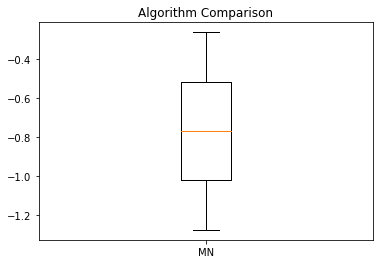

In [26]:
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [27]:
from sklearn.model_selection import GridSearchCV
model = MLPRegressor()

In [28]:
param_search = {
    "hidden_layer_sizes": [(1,),(50,),(100,),(150,),(200,)],
    "activation": ["identity", "logistic", "tanh", "relu"],
    "solver": ["lbfgs", "sgd", "adam"],
    "alpha": [0.00005,0.0005],
    "learning_rate": ['constant', 'invscaling', 'adaptive']
}

In [29]:
tsvc = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model, cv=tsvc, param_grid=param_search, scoring='r2')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [30]:
print(best_model)

MLPRegressor(activation='logistic', alpha=5e-05, hidden_layer_sizes=(50,),
             solver='lbfgs')


In [31]:
print(best_score)

-0.26329796851576237


In [32]:
from sklearn.metrics import r2_score

y_pred = best_model.predict(X_test)

print(r2_score(y_test, y_pred))

-0.575722758023917
